# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
# from util_opt import results_scenarios, run_scenario
import time
import gurobipy as grb

In [2]:
# Import Modules
import libcbm
from util_walter import run_cbm, cbm_report, plugin_c_curves, compare_ws3_cbm
from util_walter import compile_scenario, plot_scenario

In [3]:
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'

## Create and Run `ForestModel` instance

In [4]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='redchris',
                            model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

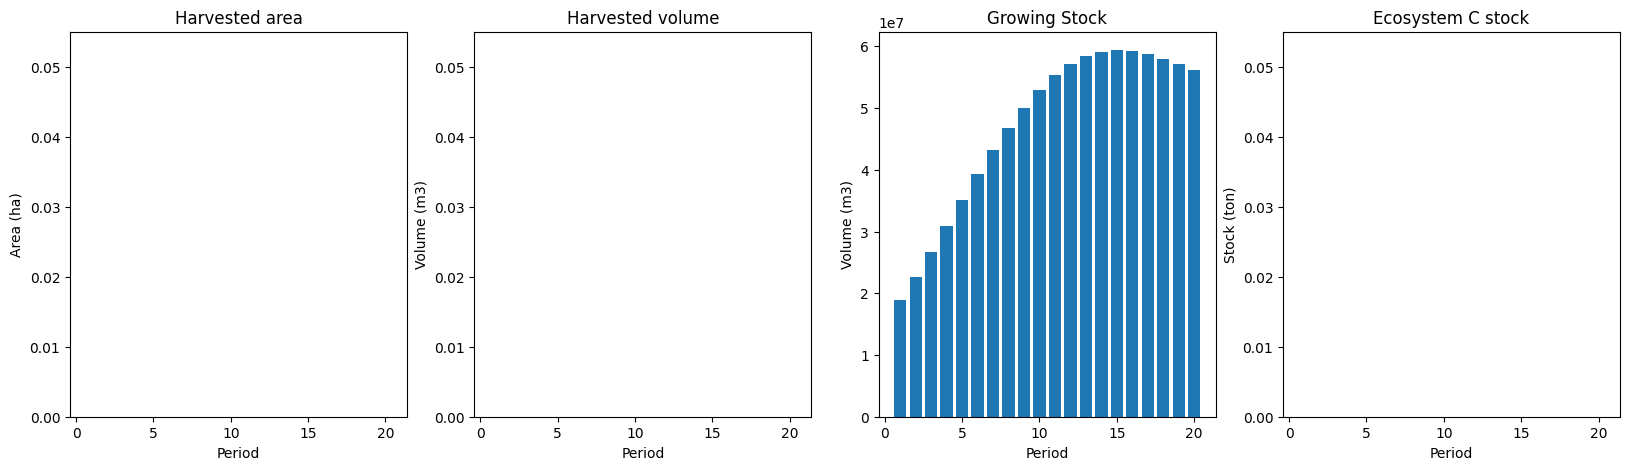

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [8]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [9]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [11]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [12]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,1.412962e+07,3.950435e+07,5.363397e+07,0.000000e+00,0.000000e+00,0.000000
1,1.432216e+07,3.939745e+07,5.371962e+07,8.773195e+05,9.629614e+05,-85641.914942
2,1.451575e+07,3.930281e+07,5.381856e+07,8.735358e+05,9.724778e+05,-98942.017982
3,1.470925e+07,3.921932e+07,5.392858e+07,8.711517e+05,9.811685e+05,-110016.764408
4,1.490350e+07,3.914618e+07,5.404969e+07,8.698809e+05,9.909924e+05,-121111.484108
...,...,...,...,...,...,...
196,2.991943e+07,5.351332e+07,8.343275e+07,1.252312e+06,1.277555e+06,-25243.198170
197,2.988949e+07,5.356798e+07,8.345747e+07,1.252278e+06,1.276999e+06,-24721.092828
198,2.985830e+07,5.362332e+07,8.348163e+07,1.252276e+06,1.276428e+06,-24152.594679


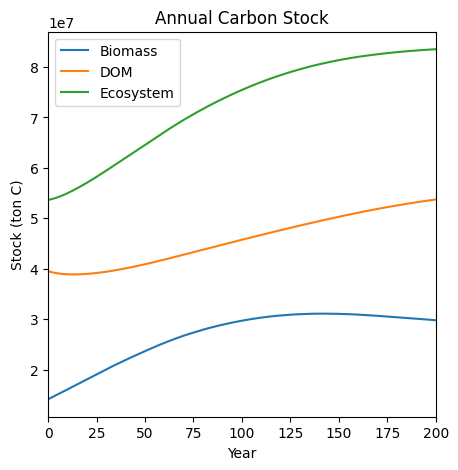

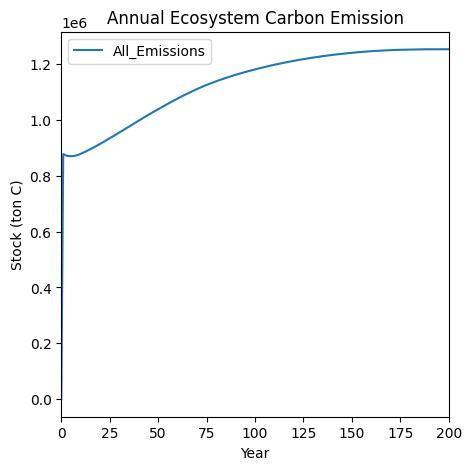

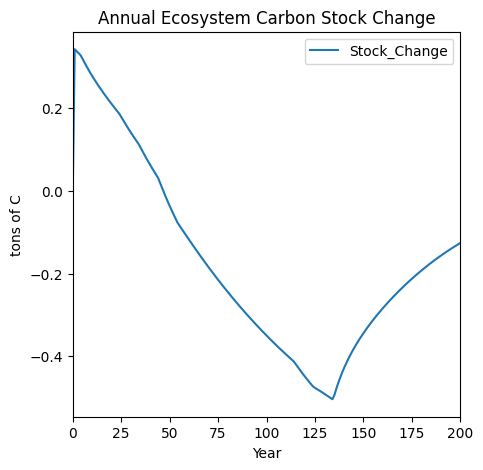

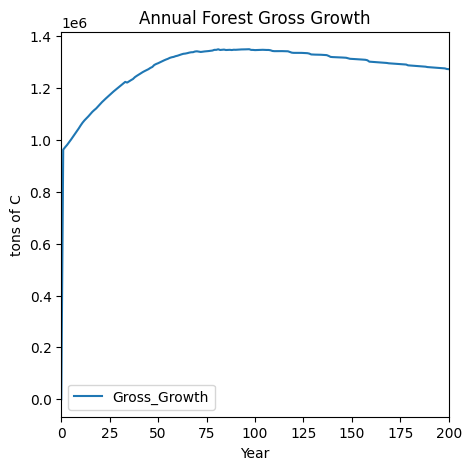

In [13]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [14]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [15]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,2,1073.692259,0,0,fire,fire
1,tsa04,0,1,304,1,1,softwood,FALSE,56,0.243633,0,0,fire,fire
2,tsa04,0,1,304,1,1,softwood,FALSE,63,7.461933,0,0,fire,fire
3,tsa04,0,1,304,1,1,softwood,FALSE,66,1.380655,0,0,fire,fire
4,tsa04,0,1,304,1,1,softwood,FALSE,70,1.875229,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4203,tsa04,1,42,1211,42,42,hardwood,FALSE,64,22.634064,0,0,fire,fire
4204,tsa04,1,42,1211,42,42,hardwood,FALSE,66,8.104135,0,0,fire,fire
4205,tsa04,1,42,1211,42,42,hardwood,FALSE,124,15.389482,0,0,fire,fire
4206,tsa04,1,42,1211,42,42,hardwood,FALSE,146,2.908943,0,0,fire,fire


In [16]:
# Set Age and Area to 0 and 1.0
df = sit_tables['sit_inventory']
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [17]:
df

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,0,1.0,0,0,fire,fire
1,tsa04,0,2,304,2,2,softwood,FALSE,0,1.0,0,0,fire,fire
2,tsa04,0,2,1201,2,2,softwood,FALSE,0,1.0,0,0,fire,fire
3,tsa04,0,3,304,3,3,softwood,FALSE,0,1.0,0,0,fire,fire
4,tsa04,0,3,1201,3,3,softwood,FALSE,0,1.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,tsa04,1,39,403,39,39,softwood,FALSE,0,1.0,0,0,fire,fire
125,tsa04,1,40,1201,40,40,hardwood,FALSE,0,1.0,0,0,fire,fire
126,tsa04,1,41,1201,41,41,hardwood,FALSE,0,1.0,0,0,fire,fire
127,tsa04,1,42,1201,42,42,hardwood,FALSE,0,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [18]:
# df_sub = df.loc[(df['theme1'] == 1) & (df['last_pass_disturbance'] == 'fire')]
# df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
# df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')
# df_sub
# df = pd.concat([df, df_sub], ignore_index=True)
# df = df.drop_duplicates(ignore_index=True)
# df

In [19]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [20]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [21]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [22]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa04,0,1,304,1,1,softwood,1.0,...,46.804448,28.616202,19.461734,0.000000,0.000000,3758.314120,4.582231,41.238806,0.0,0.0
1,2,0,tsa04,0,2,304,2,2,softwood,1.0,...,52.788135,36.275304,20.645043,0.000000,0.000000,4235.506106,5.006031,45.052911,0.0,0.0
2,3,0,tsa04,0,2,1201,2,2,softwood,1.0,...,52.788135,36.275304,20.645043,0.000000,0.000000,4235.506106,5.006031,45.052911,0.0,0.0
3,4,0,tsa04,0,3,304,3,3,softwood,1.0,...,61.447035,44.569275,21.902875,0.000000,0.000000,4914.728749,5.519610,49.674996,0.0,0.0
4,5,0,tsa04,0,3,1201,3,3,softwood,1.0,...,61.447035,44.569275,21.902875,0.000000,0.000000,4914.728749,5.519610,49.674996,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25924,125,200,tsa04,1,39,403,39,39,softwood,1.0,...,77.539605,8.003413,2.116034,0.000000,0.000000,6418.380443,6.617676,59.557429,0.0,0.0
25925,126,200,tsa04,1,40,1201,40,40,hardwood,1.0,...,85.604785,0.000000,0.000000,3.702987,1.463867,7468.930421,6.662725,59.962598,0.0,0.0
25926,127,200,tsa04,1,41,1201,41,41,hardwood,1.0,...,86.717625,0.000000,0.000000,3.526354,1.463491,7566.847583,6.680903,60.126192,0.0,0.0
25927,128,200,tsa04,1,42,1201,42,42,hardwood,1.0,...,109.038562,0.000000,0.000000,7.433382,1.472381,9657.742345,7.947739,71.527481,0.0,0.0


In [23]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,DisturbanceCO2Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa04,0,1,304,1,1,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa04,0,2,304,2,2,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa04,0,2,1201,2,2,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa04,0,3,304,3,3,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa04,0,3,1201,3,3,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25924,125,200,tsa04,1,39,403,39,39,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25925,126,200,tsa04,1,40,1201,40,40,hardwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25926,127,200,tsa04,1,41,1201,41,41,hardwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25927,128,200,tsa04,1,42,1201,42,42,hardwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [25]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [26]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0          0.000000e+00         0.000000       0.000000   
                  1          1.933007e-10         0.000071       0.000000   
                  2          8.648289e-09         0.000562       0.000000   
                  3          7.989637e-08         0.001891       0.000000   
                  4          3.869269e-07         0.004474       0.000000   
...                                   ...              ...            ...   
tsa04 1 9 105 9 9 196        6.179376e+01         7.220360      27.259301   
                  197        6.185427e+01         7.223467      27.269184   
                  198        6.191478e+01         7.226572      27.279065   
                  199        6.197528e+01         7.229675      27.288944   
                  200        6.203578e+01         7.232777      27.298822   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 0 1 304 1 1 0                    0.000000           0.000000   
                  1                    0.000009           0.000007   
                  2                    0.000072           0.000053   
                  3                    0.000241           0.000179   
                  4                    0.000570           0.000423   
...                                         ...                ...   
tsa04 1 9 105 9 9 196                 19.256988           2.115710   
                  197                 19.272825           2.116192   
                  198                 19.288658           2.116675   
                  199                 19.304489           2.117158   
                  200                 19.320317           2.117641   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
tsa04 1 9 105 9 9 196                 0.0              0.0            0.0   
                  197                 0.0              0.0            0.0   
                  198                 0.0              0.0            0.0   
                  199                 0.0              0.0            0.0   
                  200                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 0 1 304 1 1 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
tsa04 1 9 105 9 9 196                       0.0                0.0  ...   
                  197                       0.0                0.0  ...   
                  198                       0.0                0.0  ...   
                  199                       0.0                0.0  ...   
                  200                       0.0                0.0  ...   

                            AboveGroundSlowSoil  BelowGroundSlowSoil  \
dtype_key         timestep                                       

In [27]:
c_curves_f

DisturbanceCO2Production  \
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                              0.0   
                  1                              0.0   
                  2                              0.0   
                  3                              0.0   
                  4                              0.0   
...                                              ...   
tsa04 1 9 105 9 9 196                            0.0   
                  197                            0.0   
                  198                            0.0   
                  199                            0.0   
                  200                            0.0   

                            DisturbanceCH4Production  DisturbanceCOProduction  \
dtype_key         timestep                                                      
tsa04 0 1 304 1 1 0                              0.0                      0.0   
                  1                              0.0                      0.0   
                  2                              0.0                      0.0   
                  3                              0.0                      0.0   
                  4                              0.0                      0.0   
...                                              ...                      ...   
tsa04 1 9 105 9 9 196                            0.0                      0.0   
                  197                            0.0                      0.0   
                  198                            0.0                      0.0   
                  199                            0.0                      0.0   
                  200                            0.0                      0.0   

                            DisturbanceBioCO2Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 105 9 9 196                             0.0   
                  197                             0.0   
                  198                             0.0   
                  199                             0.0   
                  200                             0.0   

                            DisturbanceBioCH4Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 105 9 9 196                             0.0   
                  197                             0.0   
                  198                             0.0   
                  199                             0.0   
                  200                             0.0   

                            DisturbanceBioCOEmission  DecayDOMCO2Emission  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                              0.0             0.000000   
                  1                              0.0             2.979357   
                  2                              0.0             2.749185   
                  3                              0.0             2.559418   
                  4                              0.0             2.399090   
...                                              ...                  ...   
tsa04 1 9 105 9 9 196                            0.0             3.515755   
                  197                            0.0             3.5

In [28]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [29]:
# Generate carbon yield curves for net emission
c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [30]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0          0.000000e+00         0.000000       0.000000   
                  1          1.933007e-10         0.000071       0.000000   
                  2          8.648289e-09         0.000562       0.000000   
                  3          7.989637e-08         0.001891       0.000000   
                  4          3.869269e-07         0.004474       0.000000   
...                                   ...              ...            ...   
tsa04 1 9 105 9 9 196        6.179376e+01         7.220360      27.259301   
                  197        6.185427e+01         7.223467      27.269184   
                  198        6.191478e+01         7.226572      27.279065   
                  199        6.197528e+01         7.229675      27.288944   
                  200        6.203578e+01         7.232777      27.298822   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 0 1 304 1 1 0                    0.000000           0.000000   
                  1                    0.000009           0.000007   
                  2                    0.000072           0.000053   
                  3                    0.000241           0.000179   
                  4                    0.000570           0.000423   
...                                         ...                ...   
tsa04 1 9 105 9 9 196                 19.256988           2.115710   
                  197                 19.272825           2.116192   
                  198                 19.288658           2.116675   
                  199                 19.304489           2.117158   
                  200                 19.320317           2.117641   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
tsa04 1 9 105 9 9 196                 0.0              0.0            0.0   
                  197                 0.0              0.0            0.0   
                  198                 0.0              0.0            0.0   
                  199                 0.0              0.0            0.0   
                  200                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 0 1 304 1 1 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
tsa04 1 9 105 9 9 196                       0.0                0.0  ...   
                  197                       0.0                0.0  ...   
                  198                       0.0                0.0  ...   
                  199                       0.0                0.0  ...   
                  200                       0.0                0.0  ...   

                            SoftwoodBranchSnag  HardwoodStemSnag  \
dtype_key         timestep                                         
t

In [31]:
c_curves_f

DisturbanceCO2Production  \
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                              0.0   
                  1                              0.0   
                  2                              0.0   
                  3                              0.0   
                  4                              0.0   
...                                              ...   
tsa04 1 9 105 9 9 196                            0.0   
                  197                            0.0   
                  198                            0.0   
                  199                            0.0   
                  200                            0.0   

                            DisturbanceCH4Production  DisturbanceCOProduction  \
dtype_key         timestep                                                      
tsa04 0 1 304 1 1 0                              0.0                      0.0   
                  1                              0.0                      0.0   
                  2                              0.0                      0.0   
                  3                              0.0                      0.0   
                  4                              0.0                      0.0   
...                                              ...                      ...   
tsa04 1 9 105 9 9 196                            0.0                      0.0   
                  197                            0.0                      0.0   
                  198                            0.0                      0.0   
                  199                            0.0                      0.0   
                  200                            0.0                      0.0   

                            DisturbanceBioCO2Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 105 9 9 196                             0.0   
                  197                             0.0   
                  198                             0.0   
                  199                             0.0   
                  200                             0.0   

                            DisturbanceBioCH4Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 105 9 9 196                             0.0   
                  197                             0.0   
                  198                             0.0   
                  199                             0.0   
                  200                             0.0   

                            DisturbanceBioCOEmission  DecayDOMCO2Emission  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                              0.0             0.000000   
                  1                              0.0             2.979357   
                  2                              0.0             2.749185   
                  3                              0.0             2.559418   
                  4                              0.0             2.399090   
...                                              ...                  ...   
tsa04 1 9 105 9 9 196                            0.0             3.515755   
                  197                            0.0             3.5

Curvs Calibration

In [32]:
c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [33]:
c_curves_p

ecosystem     biomass         DOM
dtype_key         timestep                                    
tsa04 0 1 304 1 1 0         129.246888    0.000000  129.246888
                  1         126.178245    0.000089  126.178156
                  2         123.347255    0.000707  123.346548
                  3         120.712934    0.002380  120.710554
                  4         118.245657    0.005631  118.240026
...                                ...         ...         ...
tsa04 1 9 105 9 9 196       259.824376  121.175501  138.648876
                  197       260.239272  121.268020  138.971252
                  198       260.651935  121.360525  139.291410
                  199       261.062452  121.453017  139.609435
                  200       261.470900  121.545495  139.925405

[25929 rows x 3 columns]

In [34]:
# Check the total ecosystem stock change
c_curves_p['ecosystem'].diff()

dtype_key          timestep
tsa04 0 1 304 1 1  0                NaN
                   1          -3.068643
                   2          -2.830989
                   3          -2.634322
                   4          -2.467276
                                 ...   
tsa04 1 9 105 9 9  196         0.417222
                   197         0.414896
                   198         0.412663
                   199         0.410517
                   200         0.408448
Name: ecosystem, Length: 25929, dtype: float64

In [35]:
c_curves_f

total_emissions  net_fluxes
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                0.000000    0.000000
                  1                3.068738   -3.068643
                  2                2.831661   -2.830989
                  3                2.636201   -2.634322
                  4                2.471062   -2.467276
...                                     ...         ...
tsa04 1 9 105 9 9 196              3.621227    0.417222
                  197              3.625193    0.414896
                  198              3.629064    0.412663
                  199              3.632849    0.410517
                  200              3.636556    0.408448

[25929 rows x 2 columns]

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [39]:
pools_mdf = ['ecosystem', 'biomass', 'DOM']

In [40]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, pools_mdf)

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
fo

In [41]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '40', '40'),
  'a',
  [('s1201', <ws3.core.Curve at 0x7f6de4f2cc10>),
   ('ecosystem', <ws3.core.Curve at 0x7f6daef81ed0>),
   ('biomass', <ws3.core.Curve at 0x7f6daef81540>),
   ('DOM', <ws3.core.Curve at 0x7f6daef80d00>),
   ('ecosystem', <ws3.core.Curve at 0x7f6daef81ed0>),
   ('biomass', <ws3.core.Curve at 0x7f6daef81540>),
   ('DOM', <ws3.core.Curve at 0x7f6daef80d00>)]),
 (('?', '?', '?', '?', '1', '1'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7f6de4f2cbe0>),
   ('ecosystem', <ws3.core.Curve at 0x7f6daf03f1c0>),
   ('biomass', <ws3.core.Curve at 0x7f6daf03fca0>),
   ('DOM', <ws3.core.Curve at 0x7f6daf03f970>),
   ('ecosystem', <ws3.core.Curve at 0x7f6daf03f1c0>),
   ('biomass', <ws3.core.Curve at 0x7f6daf03fca0>),
   ('DOM', <ws3.core.Curve at 0x7f6daf03f970>),
   ('ecosystem', <ws3.core.Curve at 0x7f6daf03f1c0>),
   ('biomass', <ws3.core.Curve at 0x7f6daf03fca0>),
   ('DOM', <ws3.core.Curve at 0x7f6daf03f970>)]),

In [ ]:
# Load the Orginial Sit Inventory File
sit_inventory = pd.read_csv('data/libcbm_model_files_tsa24/sit_inventory.csv')

In [ ]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = sit_inventory

In [42]:
# Run CBM and generate CBM Outputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

## No Havresting Scenario

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

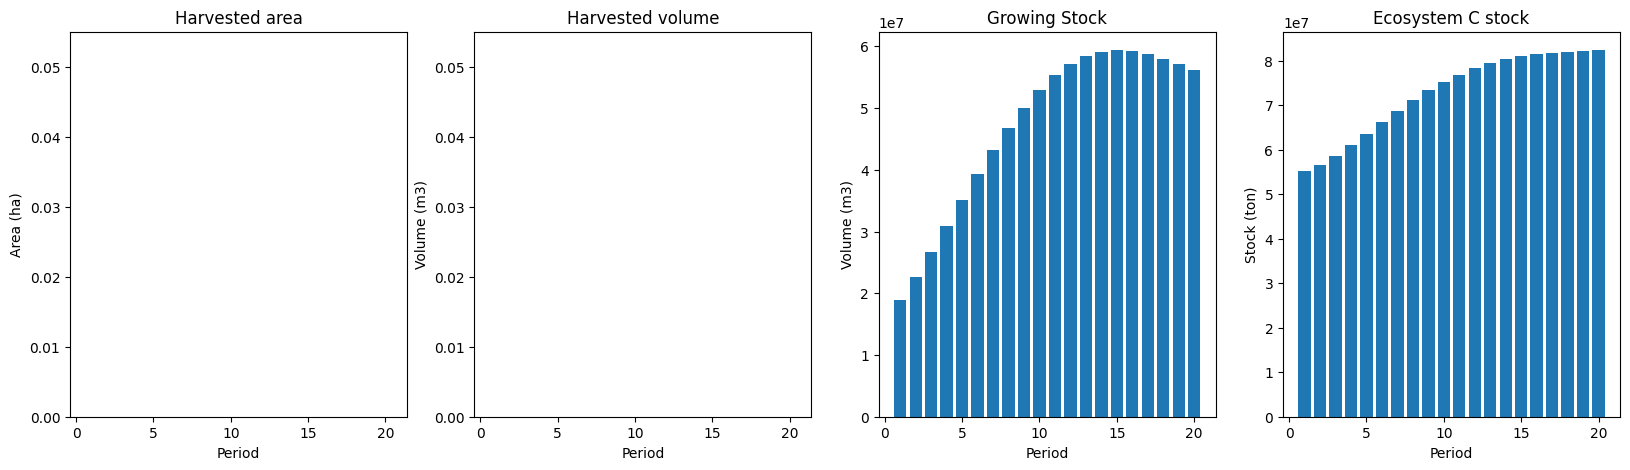

In [43]:
# Check the Forest Inventory of the ws3 Model
df = compile_scenario(fm)
plot_scenario(df)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,0.000000,21443.711719,21443.711719,0.000000,0.000000,0.000000
1,17.549820,20983.458279,21001.008099,463.248136,20.544516,442.703620
2,36.321089,20560.632242,20596.953330,430.995588,26.940820,404.054768
3,56.893034,20168.262432,20225.155466,404.722706,32.924843,371.797864
4,79.204408,19801.776040,19880.980449,382.826800,38.651782,344.175018
...,...,...,...,...,...,...
196,12341.122391,17596.312422,29937.434812,439.719846,483.051508,-43.331662
197,12352.026026,17628.537267,29980.563293,440.112967,483.241448,-43.128481
198,12362.925641,17660.570415,30023.496055,440.498524,483.431286,-42.932762


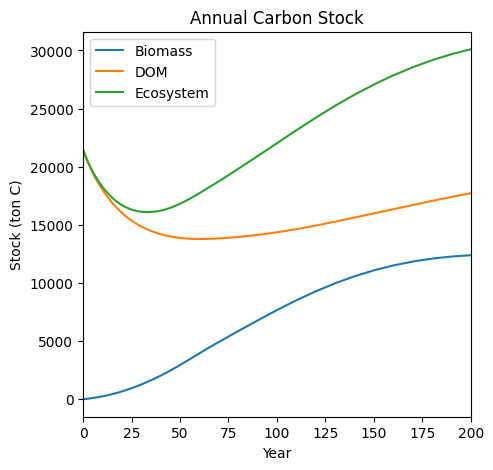

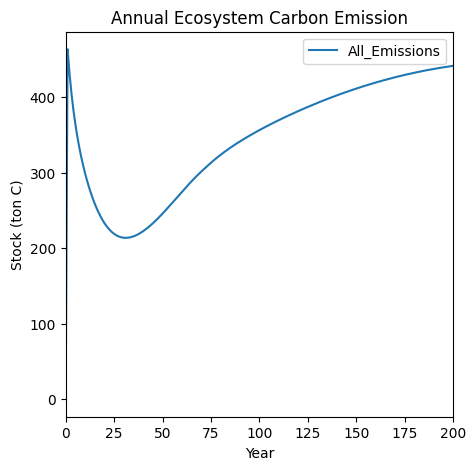

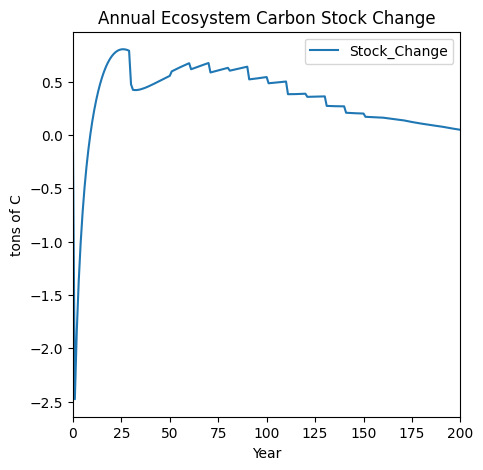

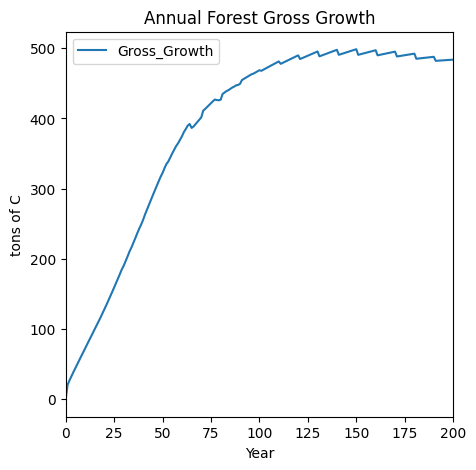

In [45]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

In [47]:
# Import Modules
from util_walter import compare_ws3_cbm

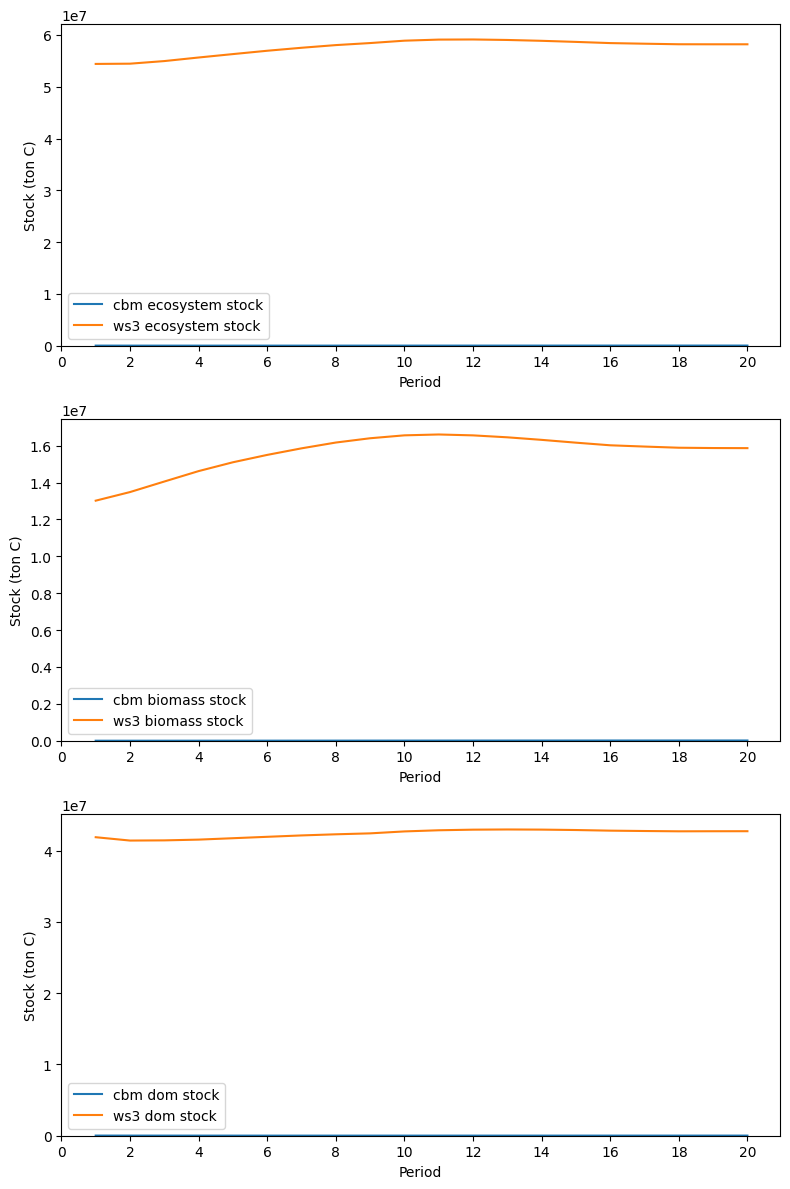

(    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0        1      17.549820  20983.458279  21001.008099          0.000000
 1        2     282.523491  17759.527276  18042.050767      -2958.957332
 2        3     720.597900  15882.368073  16602.965973      -1439.084794
 3        4    1338.537722  14772.292510  16110.830231       -492.135742
 4        5    2113.276081  14150.417858  16263.693939        152.863707
 5        6    3041.400312  13856.009695  16897.410008        633.716069
 6        7    4044.680219  13784.446103  17829.126322        931.716314
 7        8    5004.086759  13842.457517  18846.544277       1017.417955
 8        9    5947.393080  13974.322656  19921.715736       1075.171459
 9       10    6859.457879  14155.850222  21015.308101       1093.592365
 10      11    7750.841632  14385.674810  22136.516442       1121.208341
 11      12    8584.660271  14659.632446  23244.292716       1107.776274
 12      13    9348.431984  14969.927770  24318.359

In [56]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots = "individual")

The carbon outputs from cbm and ws3 fit with each other pretty well when there is no harvest!

## Old-growth First Havresting Scenario

Simulate some harvesting in all periods

In [51]:
#Reset the Forest Model
fm.reset()
#Import Modules
from util import schedule_harvest_areacontrol, compile_scenario, plot_scenario
#Schedule Area Control Havrest
sch = schedule_harvest_areacontrol(fm, 1)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

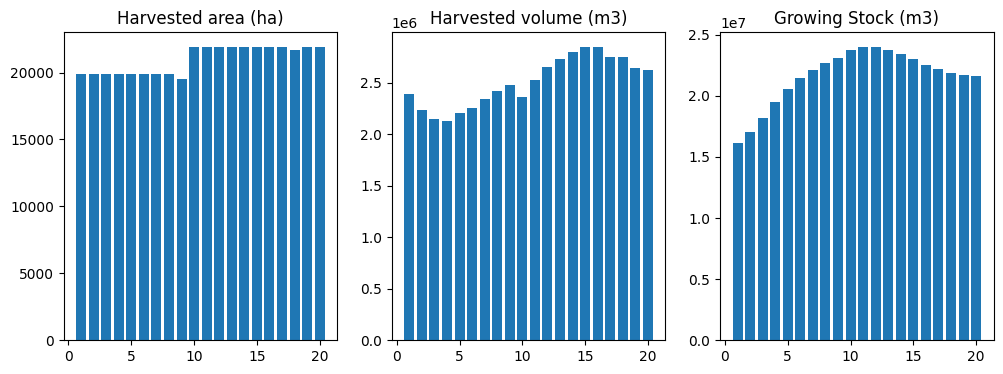

In [52]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

In [57]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [59]:
#Import Module
from util_walter_old import complie_events

In [60]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

ValueError: All arrays must be of the same length

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

## Implement Optimization-based Action Scheduling

In [ ]:
#Install Module
%pip install gurobipy

In [ ]:
#Import Module
import gurobipy as grb

In [ ]:
#Import Module
# from util import cmp_c_z,cmp_c_cflw,cmp_c_caa,cmp_c_ci,gen_scenario

Add a "null" action to the model for the optimization functions to work correctly.

In [ ]:
#Add a Null Action
fm.add_null_action()

Define base and other scenarios below. You can change you objective functions and constraints by modifying the scenarios directly.

In [ ]:
# Define Objective Function
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient for product indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_i(fm, path, yname, mask=None): # product, named actions
    """
    Compile objective function coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        result = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

In [ ]:
# Define Gen_scenario Function
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, 
                 cgen_gs={}, cgen_cp = {}, cgen_cf = {},
                 tvy_name='totvol', cp_name='ecosystem', cf_name='total_emissions', obj_mode='max_iv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = vexpr
    elif obj_mode == 'max_iv': # minimize forest inventory values
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = '1.'
    elif obj_mode == 'min_iv': # minimize forest inventory values
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_i, yname=cf_name) # define objective function coefficient function for inventory data
    # coeff_funcs['z'] = partial(cmp_c_z, expr=cp_name) # define objective function coefficient function for harvested carbon 
    # coeff_funcs['z'] = partial(cmp_c_z, expr=vexpr) # define objective function coefficient function for havrest volume 
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        # cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    if cgen_cp: # define general constraint (carbon pools)
        cname = 'cgen_cp'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=cp_name, mask=None)
        cgen_data[cname] = cgen_cp
    if cgen_cf: # define general constraint (carbon fluxes)
        cname = 'cgen_cf'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=cf_name, mask=None)
        cgen_data[cname] = cgen_cf
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [ ]:
# Define Run_scenario Function
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    cgen_cp = {}
    cgen_cf = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    in_cp = 1412181000. #initial total ecosystem carbon stock
    # in_cf = 580000000 #intial total ecosystem carbon emission
    AAC = 7031963. # AAC of TSA24

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{10:in_gs*10}, 'ub':{10:in_gs*10+1}}
    elif scenario_name == 'base_h': 
        # Base scenario
        print('running maxmizie harvest scenario')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{1:AAC}} #Achieve the Annual Allowable Cut
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with even-flow constraints')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.5}, 'ub':{1:AAC*2}}  #Not less than 10% of annual allowable cut
        # cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}   
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,
                     cgen_cp=cgen_cp,
                     cgen_cf=cgen_cf)

    fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        # sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

## Maximize Havrest Volume without Any Constraints

In [ ]:
run_scenario(fm,'base')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Havrest Volume with Harvesting and Growing Stock Constraints

In [ ]:
run_scenario(fm,'base_h')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

The Carbon Outputs from ws3 and libcbm still looks good when maxmizing the harvest volum from the forest

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Total Ecosystem Carbon Storage without Any Constraints

In [ ]:
# Maximize Total Ecosystem Carbon Storage
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

There will be the least harvesting activities if the target is to maxmize the total ecosystem carbon stock

## Maximize Total Ecosystem Carbon Storage with Harvesting and Growing Stock Constraints

In [ ]:
# Maximize Total Ecosystem Carbon Storage with Minimum and Maximum Harvest  Level and Total Growing Stock Constraints
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Minimize Total Carbon Emissions without Any Constrations

There will be the least harvesting activities if the target is to maxmize the total ecosystem carbon stock

In [ ]:
# Minimize Total Carbon Emissions
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Minimize Total Carbon Emissions with Harvesting and Growing Stock Constraints

In [ ]:
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Total Ecosystem Carbon Sequestration without Constraints

In [ ]:
# Maxmize Total Ecosystem Carbon Sequestration with Havrest and Growing Stock Constraints
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Total Ecosystem Carbon Sequestration with Harvesting and Growing Stock Constraints

In [ ]:
# Maxmize Total Ecosystem Carbon Sequestration with Havrest and Growing Stock Constraints
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)